In [ ]:
# | default_exp project.models.bert.training
# %matplotlib inline

# Bert Training

In [ ]:
import random

import numpy as np

# | export
# Fix seed for experimenting
import torch


def manual_seed_all(
    seed,
):
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    np.random.seed(seed)
    random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
import collections
import json

# | export
import os
from random import (
    shuffle,
)

import torch
import torch.nn.functional as F
from project.models.bert.model import (
    BERT,
)
from project.utils.plot import (
    LivePlot,
)
from torch import (
    nn,
)
from torch.utils.data import (
    DataLoader,
    TensorDataset,
)
from transformers import (
    AdamW,
    BertConfig,
    BertForMaskedLM,
    BertTokenizer,
)


def mask_theorem(
    token_theorem,
    tokenizer,
    max_masked=40,
):
    theo_indices = []
    for i in range(
        1,
        len(token_theorem),
    ):  # don't mask [CLS] and [END] or spaces and new lines
        if token_theorem[i] == tokenizer.sep_token_id:
            break
        theo_indices.append(i)

    shuffle(theo_indices)
    masked_poss = theo_indices[:max_masked]
    masked_tokens = []
    for i in masked_poss:
        masked_tokens.append(token_theorem[i])
        token_theorem[i] = tokenizer.mask_token_id
    return (
        token_theorem,
        masked_tokens,
        masked_poss,
    )


if "tmp_data_dir" in os.environ:
    tmp_data_dir = os.environ["tmp_data_dir"]
else:
    TMP_RELATIVE_DATA_PATH = "../.tmp/data"
    notebook_path = os.getcwd()
    tmp_data_dir = os.path.join(
        notebook_path,
        TMP_RELATIVE_DATA_PATH,
    )


def load_from_json(
    filename,
):
    print(f"Loading: {filename}")
    with open(
        filename,
        "r",
    ) as f:
        data = json.load(f)
    return data


def save_to_json(
    data,
    filename,
):
    print(f"Saving: {filename}")
    with open(
        filename,
        "w",
    ) as f:
        json.dump(
            data,
            f,
        )


def create_dataloader(
    data_file,
    max_masked=1,
    batch_size=4,
    max_length=1024,
    cap_train_data=None,
    tokenizer=None,
):
    batch = load_from_json(data_file)  # [(tokens, masked_tokens, masked_pos)]
    if cap_train_data and cap_train_data > 0:
        batch = batch[0:cap_train_data]

    assert tokenizer is not None, "Tokenizer is None, and must be provider"

    masked_batch = []
    for theo in batch:
        token_theorem = tokenizer.encode_plus(
            theo,
            padding="max_length",
            max_length=max_length,
        )
        (
            input_ids_list,
            masked_tokens,
            masked_poss,
        ) = mask_theorem(
            token_theorem["input_ids"],
            tokenizer,
            max_masked=max_masked,
        )
        masked = torch.LongTensor(masked_tokens).cuda()
        masked_poss = torch.LongTensor(masked_poss).cuda()
        input_ids = torch.LongTensor(input_ids_list).cuda()
        attention_mask = torch.LongTensor(token_theorem["attention_mask"]).cuda()
        masked_batch.append(
            (
                input_ids,
                attention_mask,
                masked,
                masked_poss,
            )
        )

    (
        input_ids,
        attention_mask,
        masked_tokens,
        masked_poss,
    ) = list(zip(*masked_batch))
    input_ids = torch.stack(input_ids).squeeze(1)
    attention_mask = torch.stack(attention_mask).squeeze(1)

    masked_tokens = torch.stack(masked_tokens)
    masked_poss = torch.stack(masked_poss)

    dataset = TensorDataset(
        input_ids,
        attention_mask,
        masked_tokens,
        masked_poss,
    )
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
    )
    return (
        dataloader,
        tokenizer.vocab_size,
    )


class BERTEvaluator:
    def __init__(
        self,
        model_file,
        tokenizer,
        vocab_size,
        num_heads=6,
        n_layers=6,
        d_model=1000,
        max_length=1024,
    ):
        config = BertConfig(
            vocab_size=vocab_size,
            hidden_size=d_model,
            num_hidden_layers=n_layers,
            max_length=max_length,
            num_attention_heads=num_heads,
            intermediate_size=2048,
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1,
            max_position_embeddings=max_length,
            initializer_range=0.0001,
        )

        # Initialize the model
        model = BertForMaskedLM(config).cuda()

        # Load the state dictionary
        state_dict = torch.load(model_file)

        # Load this state dictionary into your BERT model
        model.load_state_dict(state_dict)

        self.model = model
        self.model.eval()
        self.tokenizer = tokenizer

    def evaluate(
        self,
        output_path,
        dataloader_val,
    ):
        # Evaluate the model
        minibatch_val_n = 0
        running_accuracy = 0.0
        n_batches_val = len(dataloader_val)
        print(f"==> Validating Epoch <==")
        progress: list[dict] = [{"validation": []}]
        with torch.no_grad():
            for (
                input_ids,
                attention_mask,
                masked_tokens,
                masked_poss,
            ) in dataloader_val:
                output = self.model(
                    input_ids,
                    attention_mask=attention_mask,
                )
                logits = output.logits
                mask_positions = torch.where(input_ids == self.tokenizer.mask_token_id)

                # Extract logits for the [MASK] positions
                mask_logits = logits[
                    mask_positions[0],
                    mask_positions[1],
                    :,
                ]
                # Get the predicted token IDs for all [MASK] positions
                predicted_token_ids = torch.argmax(
                    mask_logits,
                    dim=1,
                )
                # Convert the predicted token IDs to tokens
                predicted_tokens = [self.tokenizer.decode(token_id) for token_id in predicted_token_ids]

                # Convert the predicted token IDs to tokens
                masked_logits = torch.gather(
                    logits,
                    1,
                    masked_poss.unsqueeze(-1).expand(
                        -1,
                        -1,
                        logits.size(-1),
                    ),
                )
                accuracy = (predicted_token_ids == masked_tokens).float().mean().item()
                running_accuracy += accuracy
                predictions_list = []
                for (
                    p,
                    l,
                ) in zip(
                    predicted_tokens,
                    masked_tokens,
                ):
                    zipped_lp = zip(
                        l,
                        p,
                    )
                    predict = [
                        (
                            "".join(self.tokenizer.decode(ll)),
                            "".join(pp),
                        )
                        for ll, pp in zipped_lp
                    ]
                    predictions_list.append(" @ ".join([f"{pr[0]}<>{pr[1]})" for pr in predict]))
                print(f"Validation Minibatch: {minibatch_val_n}, Accuracy: {accuracy}, Accum Accuracy: {running_accuracy}")
                prediction_str = " # ".join(predictions_list)
                print(
                    "Predictions: ",
                    prediction_str,
                )
                progress[-1]["validation"].append(
                    {
                        "predictions": prediction_str,
                        "accuracy": accuracy,
                        "acum_accuracy": running_accuracy,
                    }
                )
                minibatch_val_n += 1
            total_accuracy = running_accuracy / n_batches_val
            save_to_json(
                {"accuracy": total_accuracy},
                os.path.join(
                    output_path,
                    "evaluation.json",
                ),
            )
            return total_accuracy


class BERTTrainer:
    def __init__(
        self,
        dataloader,
        dataloader_val,
        vocab_size,
        num_heads=6,
        n_layers=6,
        d_model=1000,
        max_length=1024,
        tokenizer=None,
        criterion=None,
        optimizer=torch.optim.SGD,
        gradient_accumulation_steps=1,
    ):
        self.tokenizer = tokenizer
        self.num_heads = num_heads
        self.n_layers = n_layers
        self.d_model = d_model
        self.max_length = max_length

        assert tokenizer is not None, "Tokenizer is None, and must be provider"
        assert criterion is not None, "Criterion is None, and must be provider"
        self.tokenizer = tokenizer

        print("Create BERTodel")
        config = BertConfig(
            vocab_size=vocab_size,
            hidden_size=d_model,
            num_hidden_layers=n_layers,
            max_length=max_length,
            num_attention_heads=num_heads,
            intermediate_size=2048,
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1,
            max_position_embeddings=max_length,
            initializer_range=0.0001,
        )

        model = BertForMaskedLM(config).cuda()

        self.model = model
        self.dataloader = dataloader
        self.dataloader_val = dataloader_val

        print(
            "Current GPU memory usage:",
            torch.cuda.memory_allocated(),
        )
        print(
            "Maximum GPU memory usage:",
            torch.cuda.max_memory_allocated(),
        )

        self.criterion = criterion.cuda()
        self.optimizer = optimizer(
            model.parameters(),
            lr=0.001,
        )  # torch.optim.Adam(model.parameters(), lr=0.001)
        num_params = sum(p.numel() for p in model.parameters())
        print(f"Number of parameters: {num_params/(1000000)} Millions")

        self.gradient_accumulation_steps = gradient_accumulation_steps

    def evaluate(
        self,
        output_path,
        dataloader_val,
        model,
        tokenizer,
        criterion,
        progress,
        epoch=0,
        train_loss=0,
    ):
        # Evaluate the model
        minibatch_val_n = 0
        accum_val_loss = 0.0
        running_accuracy = 0.0
        n_batches_val = len(dataloader_val)
        print(f"==> Validating Epoch {epoch} <==")
        model.eval()
        progress.append({"validation": []})
        with torch.no_grad():
            for (
                input_ids,
                attention_mask,
                masked_tokens,
                masked_poss,
            ) in dataloader_val:
                output = model(
                    input_ids,
                    attention_mask=attention_mask,
                )
                logits = output.logits
                mask_positions = torch.where(input_ids == tokenizer.mask_token_id)

                # Extract logits for the [MASK] positions
                mask_logits = logits[
                    mask_positions[0],
                    mask_positions[1],
                    :,
                ]
                # Get the predicted token IDs for all [MASK] positions
                predicted_token_ids = torch.argmax(
                    mask_logits,
                    dim=1,
                )
                # Convert the predicted token IDs to tokens
                predicted_tokens = [tokenizer.decode(token_id) for token_id in predicted_token_ids]

                # Convert the predicted token IDs to tokens
                masked_logits = torch.gather(
                    logits,
                    1,
                    masked_poss.unsqueeze(-1).expand(
                        -1,
                        -1,
                        logits.size(-1),
                    ),
                )
                loss_lm = criterion(
                    masked_logits.transpose(
                        1,
                        2,
                    ),
                    masked_tokens,
                )
                loss_lm = (loss_lm.float()).mean()
                accum_val_loss += loss_lm.item()
                accuracy = (predicted_token_ids == masked_tokens).float().mean().item()
                running_accuracy += accuracy
                predictions_list = []
                for (
                    p,
                    l,
                ) in zip(
                    predicted_tokens,
                    masked_tokens,
                ):
                    zipped_lp = zip(
                        l,
                        p,
                    )
                    predict = [
                        (
                            "".join(tokenizer.decode(ll)),
                            "".join(pp),
                        )
                        for ll, pp in zipped_lp
                    ]
                    predictions_list.append(" @ ".join([f"{pr[0]}<>{pr[1]})" for pr in predict]))
                print(f"Validation Epoch: {epoch}, Validation Minibatch: {minibatch_val_n}, Validation Loss: {loss_lm.item()}, Accuracy: {accuracy}, Accum Accuracy: {running_accuracy}")
                prediction_str = " # ".join(predictions_list)
                progress[-1]["validation"].append(
                    {
                        "predictions": prediction_str,
                        "eval_loss": loss_lm.item(),
                        "mean_train_loss": train_loss,
                        "accuracy": accuracy,
                        "acum_accuracy": running_accuracy,
                    }
                )
                minibatch_val_n += 1
            return (
                accum_val_loss,
                running_accuracy,
                n_batches_val,
            )

    def train(
        self,
        lr=0.001,
        epochs=20,
        output_path=None,
        graph=False,
    ):
        if not output_path:
            output_path = "./"

        print(f"Output path: {output_path}")
        torch.cuda.set_device(0)
        data_plot_loss = collections.defaultdict(list)
        data_plot_accuracy = collections.defaultdict(list)
        live_plot_loss = LivePlot()
        train_summary: dict = {
            "epoch_summary": [],
            "metadata": {
                "lr": lr,
                "ds_model": self.d_model,
                "num_heads": self.num_heads,
                "n_layers": self.n_layers,
            },
        }
        progress: list = []
        n_batches = len(self.dataloader)
        for epoch in range(epochs):
            print(f"==> Training Epoch {epoch} <==")
            train_loss_acum = 0
            self.model.train()
            for (
                step,
                (
                    input_ids,
                    attention_mask,
                    masked_tokens,
                    masked_poss,
                ),
            ) in enumerate(self.dataloader):
                output = self.model(
                    input_ids,
                    attention_mask=attention_mask,
                )
                logits_lm = output.logits
                masked_logits = torch.gather(
                    logits_lm,
                    1,
                    masked_poss.unsqueeze(-1).expand(
                        -1,
                        -1,
                        logits_lm.size(-1),
                    ),
                )
                loss_lm = self.criterion(
                    masked_logits.transpose(
                        1,
                        2,
                    ),
                    masked_tokens,
                )
                loss_lm = (loss_lm.float()).mean()
                loss_lm.backward()
                loss_value = loss_lm.item()
                train_loss_acum += loss_value

                data_plot_loss[f"Epoch-{epoch}"].append(loss_value)
                if graph:
                    live_plot_loss.plot(data_plot_loss)
                if (step + 1) % self.gradient_accumulation_steps == 0:
                    self.optimizer.step()
                    self.model.zero_grad()
                if (step + 1) % 5 == 0:
                    print(f"Epoch: {epoch}, Step: {step+1}, Loss: {loss_value}")

            train_loss = train_loss_acum / n_batches

            (
                accum_val_loss,
                running_accuracy,
                n_batches_val,
            ) = self.evaluate(
                output_path,
                self.dataloader_val,
                self.model,
                self.tokenizer,
                self.criterion,
                progress,
                epoch,
            )
            save_to_json(
                progress,
                os.path.join(
                    output_path,
                    f"train-validation.json",
                ),
            )

            mean_val_loss = accum_val_loss / n_batches_val
            mean_val_accuracy = running_accuracy / n_batches_val
            train_summary["epoch_summary"].append(  # type: ignore
                {
                    "mean_validation_loss": mean_val_loss,
                    "mean_train_loss": train_loss,
                    "mean_accuracy": mean_val_accuracy,
                }
            )
            save_to_json(
                train_summary,
                os.path.join(
                    output_path,
                    f"train-summary.json",
                ),
            )

            print(
                "Saving model for Epoch [{}], Validatoin Loss: {:.4f}, Mean Accuracy: {} ".format(
                    epoch,
                    mean_val_loss,
                    mean_val_accuracy,
                )
            )
            torch.save(
                self.model.state_dict(),
                os.path.join(
                    output_path,
                    f"bert.pth",
                ),
            )

In [ ]:
manual_seed_all(42)

# Baseline

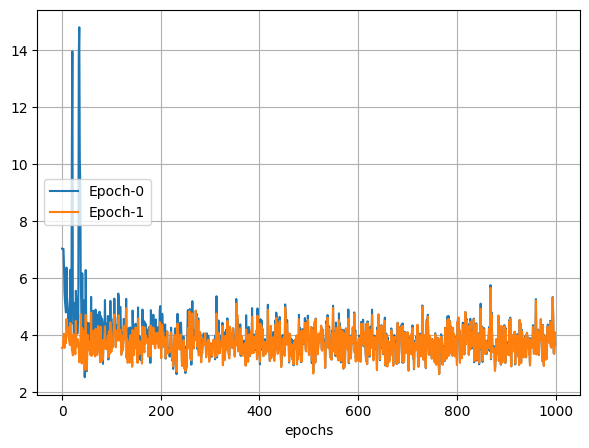

Epoch: 1, Step: 1000, Loss: 3.6355597972869873
==> Validating Epoch 1 <==
Validation Epoch: 1, Validation Minibatch: 0, Validation Loss: 3.2343013286590576, Accuracy: 0.19999998807907104, Accum Accuracy: 0.19999998807907104
Validation Epoch: 1, Validation Minibatch: 1, Validation Loss: 3.677597761154175, Accuracy: 0.0, Accum Accuracy: 0.19999998807907104
Validation Epoch: 1, Validation Minibatch: 2, Validation Loss: 3.299574613571167, Accuracy: 0.0, Accum Accuracy: 0.19999998807907104
Validation Epoch: 1, Validation Minibatch: 3, Validation Loss: 3.256929874420166, Accuracy: 0.0, Accum Accuracy: 0.19999998807907104
Validation Epoch: 1, Validation Minibatch: 4, Validation Loss: 3.207672119140625, Accuracy: 0.19999998807907104, Accum Accuracy: 0.3999999761581421
Validation Epoch: 1, Validation Minibatch: 5, Validation Loss: 3.880948305130005, Accuracy: 0.09999999403953552, Accum Accuracy: 0.4999999701976776
Validation Epoch: 1, Validation Minibatch: 6, Validation Loss: 3.7362587451934814

In [ ]:
max_length = 1024
d_model = 1000
num_heads = 10
gradient_accumulation_steps = 2
tokenizer = BertTokenizer(
    vocab_file=os.path.join(
        tmp_data_dir,
        "training",
        "vocab.txt",
    )
)
tokenizer.eos_token = "[SEP]"
tokenizer.bos_token = "[CLS]"
tokenizer.mask_token = "[MASK]"
tokenizer.unknown_token = "[UNK]"
tokenizer.pad_token = "[PAD]"

criterion = nn.CrossEntropyLoss()
optimizer = AdamW
# optimizer=torch.optim.Adam
# optimizer=torch.optim.SGD
# optimizer=torch.optim.Adagrad
# optimizer=torch.optim.Adadelta
# optimizer=torch.optim.RMSprop
print("Loading Datasets")
data_file_training = os.path.join(
    tmp_data_dir,
    "training",
    f"theorems.json",
)
data_file_validate = os.path.join(
    tmp_data_dir,
    "validation",
    f"theorems.json",
)
(
    dataloader,
    vocab_size,
) = create_dataloader(
    data_file_training,
    max_length=max_length,
    max_masked=1,
    batch_size=10,
    cap_train_data=10000,
    tokenizer=tokenizer,
)
(
    dataloader_val,
    _,
) = create_dataloader(
    data_file_validate,
    max_length=max_length,
    max_masked=1,
    batch_size=10,
    cap_train_data=10000,
    tokenizer=tokenizer,
)


print("Setting up BERT")
bert_trainer = BERTTrainer(
    dataloader,
    dataloader_val,
    vocab_size,
    max_length=max_length,
    d_model=d_model,
    num_heads=num_heads,
    n_layers=6,
    tokenizer=tokenizer,
    criterion=criterion,
    optimizer=optimizer,
    gradient_accumulation_steps=gradient_accumulation_steps,
)

print("Start Training")
bert_trainer.train(
    lr=0.001,
    epochs=2,
    output_path=os.path.join(
        tmp_data_dir,
        "training",
    ),
    graph=True,
)

In [ ]:
from transformers import (
    BertTokenizer,
)

max_length = 1024
d_model = 1000
num_heads = 10

tokenizer = BertTokenizer(
    vocab_file=os.path.join(
        tmp_data_dir,
        "training",
        "vocab.txt",
    )
)
tokenizer.eos_token = "[SEP]"
tokenizer.bos_token = "[CLS]"
tokenizer.mask_token = "[MASK]"
tokenizer.unknown_token = "[UNK]"
tokenizer.pad_token = "[PAD]"


data_file_validate = os.path.join(
    tmp_data_dir,
    "validation",
    f"theorems.json",
)
(
    dataloader_val,
    vocab_size,
) = create_dataloader(
    data_file_validate,
    max_length=max_length,
    max_masked=1,
    batch_size=10,
    cap_train_data=100,
    tokenizer=tokenizer,
)

evaluator = BERTEvaluator(
    model_file=os.path.join(
        tmp_data_dir,
        "training",
        f"bert.pth",
    ),
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
)
evaluator.evaluate(
    output_path="./",
    dataloader_val=dataloader_val,
)